In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
titanic_df = pd.read_csv('datasets/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df = titanic_df.drop(columns={'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'})
titanic_df = pd.get_dummies(titanic_df, columns=['Sex']).drop(columns='Sex_female')
titanic_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,0
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,0,3,35.0,8.0500,1


In [4]:
titanic_df.isna().any()

Survived    False
Pclass      False
Age          True
Fare        False
Sex_male    False
dtype: bool

In [5]:
titanic_df = titanic_df.fillna({'Age': titanic_df['Age'].median()})
titanic_df.isna().any()

Survived    False
Pclass      False
Age         False
Fare        False
Sex_male    False
dtype: bool

In [6]:
from sklearn.model_selection import train_test_split
X = titanic_df.drop(columns='Survived')
y = titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Простой kNN

Простой kNN с евклидовой метрикой. Поиск соседей производится полным перебором. Выбирается наиболее частый класс.

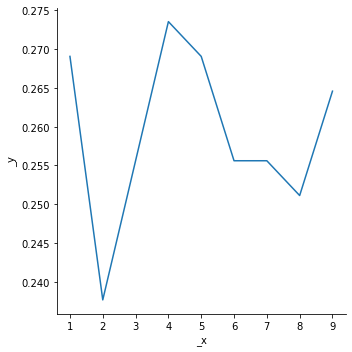

In [7]:
from metric_methods import kNearestNeighbors
from quality_functional import Accuracy

accuracies = []

for k in range(1, 10):
    kNN = kNearestNeighbors(k=k, X = X_train, y = y_train, metric='euclidian',
                                choice_method='maxentry', search_method='exhaustive')
    y_pred = kNN.predict(X_test)
    accuracies.append(Accuracy.get_accuracy(y_pred, y_test.to_numpy()))
sns.relplot(x=list(range(1, 10)), y=accuracies, kind='line')

Полный перебор работает очень медленно

Тот же kNN, но метрика манхеттоновская.

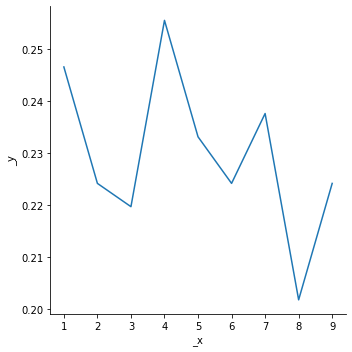

In [8]:
accuracies = []

for k in range(1, 10):
    kNN = kNearestNeighbors(k=k, X = X_train, y = y_train, metric='manhattan',
                                choice_method='maxentry', search_method='exhaustive')
    y_pred = kNN.predict(X_test)
    accuracies.append(Accuracy.get_accuracy(y_pred, y_test.to_numpy()))
sns.relplot(x=list(range(1, 10)), y=accuracies, kind='line')

Косинусное расстояние

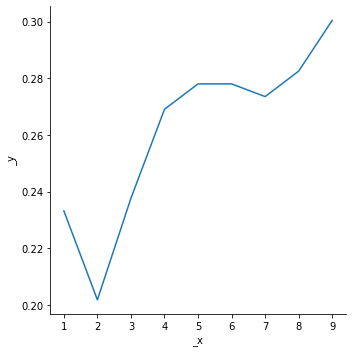

In [9]:
accuracies = []

for k in range(1, 10):
    kNN = kNearestNeighbors(k=k, X = X_train, y = y_train, metric='cosine',
                                choice_method='maxentry', search_method='exhaustive')
    y_pred = kNN.predict(X_test)
    accuracies.append(Accuracy.get_accuracy(y_pred, y_test.to_numpy()))
sns.relplot(x=list(range(1, 10)), y=accuracies, kind='line')

Взвешенный kNN (гауссовское ядро)

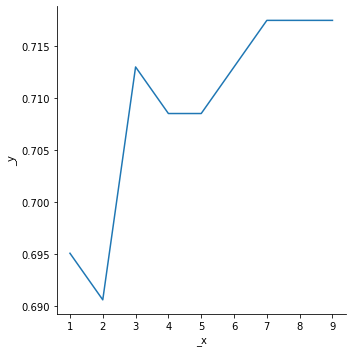

In [12]:
accuracies = []
max_score = 0
best_k = None
for k in range(1, 10):
    kNN = kNearestNeighbors(k=k, X = X_train, y = y_train, metric='euclidian',
                                choice_method='weighted', search_method='exhaustive',
                               window_width=1)
    y_pred = kNN.predict(X_test)
    acc = Accuracy.get_accuracy(y_pred, y_test.to_numpy())
    if acc > max_score:
        max_score = acc
        best_k = k
    accuracies.append(acc)
sns.relplot(x=list(range(1, 10)), y=accuracies, kind='line')

Подберем ширину окна (k оставим равным best_k)

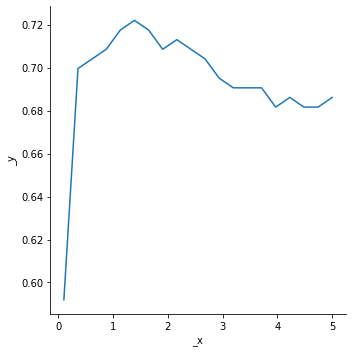

In [13]:
accuracies = []
for h in np.linspace(0.1, 5, num=20):
    kNN = kNearestNeighbors(k=best_k, X = X_train, y=y_train, metric='euclidian',
                               choice_method='weighted', window_width=h, search_method='exhaustive')
    y_pred = kNN.predict(X_test)
    accuracies.append(Accuracy.get_accuracy(y_pred, y_test.to_numpy()))
sns.relplot(x=np.linspace(0.1, 5, num=20), y=accuracies, kind='line')

# Ядерная регрессия

In [23]:
from data import normalize_columns
from sklearn.model_selection import train_test_split

weather_ds = pd.read_csv('datasets/weatherHistory.csv')
weather_ds = weather_ds[['Precip Type', 'Humidity', 'Pressure (millibars)', 'Temperature (C)']]
weather_ds = pd.get_dummies(weather_ds, prefix='precip', columns=['Precip Type'])
weather_ds = weather_ds.rename(columns={'Pressure (millibars)': 'Pressure'})
normalize_columns(weather_ds, columns=['Pressure'])
X = weather_ds.drop(columns=['Temperature (C)'])
y = weather_ds['Temperature (C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=500, test_size=200)

In [24]:
weather_ds

,Humidity,Pressure,Temperature (C),precip_rain,precip_snow
0,0.89,0.970135,9.472222,1,0
1,0.86,0.970613,9.355556,1,0
2,0.89,0.970909,9.377778,1,0
3,0.83,0.971358,8.288889,1,0
4,0.83,0.971454,8.755556,1,0
...,...,...,...,...,...
96448,0.43,0.969399,26.016667,1,0
96449,0.48,0.970164,24.583333,1,0
96450,0.56,0.970642,22.038889,1,0
96451,0.60,0.970919,21.522222,1,0


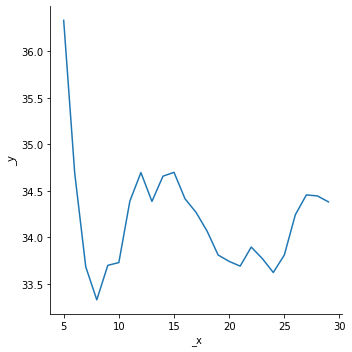

In [29]:
from quality_functional import MSE
from metric_methods import kNearestNeighbors

MSEs = []

for k in range(5, 30):
    kernel_knn = kNearestNeighbors(k, X_train, y_train,
                                      choice_method='kernel-regression', window_width=1)
    y_pred = kernel_knn.predict(X_test)
    MSEs.append(MSE.get_loss(y_test, y_pred))
sns.relplot(x=list(range(5, 30)), y=MSEs, kind='line')

При достаточно хорошей обучающей выборке показывает результат лучше чем линейная регрессия

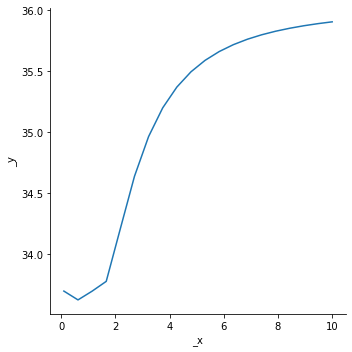

In [26]:
MSEs = []

for h in np.linspace(0.1, 10, 20):
    kernel_knn = kNearestNeighbors(20, X_train, y_train,
                                      choice_method='kernel-regression', window_width=h)
    y_pred = kernel_knn.predict(X_test)
    MSEs.append(MSE.get_loss(y_test, y_pred))
sns.relplot(x=np.linspace(0.1, 10, 20), y=MSEs, kind='line')